In [1]:
import numpy as np
import pandas as pd
import scipy, scipy.io
import matplotlib.pyplot as plt
import datetime
import cv2

%matplotlib inline

# Data Preparation

We'll load in the data, examine what we've got, etc...

## Load the Data

The metadata is in a .mat file, so we'll have some funky formatting to take care of.

In [3]:
# Convert the metadata MAT file. Due to unweildy formatting, this is easiest by to do by hand.

# Load the MAT
dat = scipy.io.loadmat('/data/wiki_crop/wiki.mat')

# Create the dataframe.
df_raw = pd.DataFrame(index=range(62328), 
                  columns=['dob', 'photo_yr', 'age', 'file_path', 'gender', 
                           'name', 'face_loc', 'face_score', 'second_face'],
                  data=0)

# Load in individual rows. DOB Comes in ordinal format.
df_raw.dob = [datetime.date.fromordinal(x).year for x in dat['wiki'][0][0][0][0]]
df_raw.photo_yr = dat['wiki'][0][0][1][0]
df_raw.age = df_raw.photo_yr - df_raw.dob
df_raw.file_path = ['/data/wiki_crop/' + x[0] for x in dat['wiki'][0][0][2][0]]
df_raw.gender = dat['wiki'][0][0][3][0]
df_raw.name = dat['wiki'][0][0][4][0]
df_raw.face_loc = [x[0] for x in dat['wiki'][0][0][5][0]]
df_raw.face_score = dat['wiki'][0][0][6][0]
df_raw.second_face = dat['wiki'][0][0][7][0]

# Display results.
df_raw.head()

,dob,photo_yr,age,file_path,gender,name,face_loc,face_score,second_face
0,1982,2009,27,/data/wiki_crop/17/10000217_1981-05-05_2009.jpg,1.0,[Sami Jauhojärvi],"[111.291094733, 111.291094733, 252.669930818, ...",4.300962,NaN
1,1926,1964,38,/data/wiki_crop/48/10000548_1925-04-04_1964.jpg,1.0,[Dettmar Cramer],"[252.483302295, 126.681651148, 354.531925962, ...",2.645639,1.949248
2,1949,2008,59,/data/wiki_crop/12/100012_1948-07-03_2008.jpg,1.0,[Marc Okrand],"[113.52, 169.84, 366.08, 422.4]",4.329329,NaN
3,1931,1961,30,/data/wiki_crop/65/10001965_1930-05-23_1961.jpg,1.0,[Aleksandar Matanović],"[1, 1, 634, 440]",-inf,NaN
4,1972,2012,40,/data/wiki_crop/16/10002116_1971-05-31_2012.jpg,0.0,[Diana Damrau],"[171.610314052, 75.5745123976, 266.766115706, ...",3.408442,NaN


## Examine the Data

Let's see what we've got!

In [4]:
# Any missing data?
df_raw.isnull().sum()

dob                0
photo_yr           0
age                0
file_path          0
gender          2643
name               0
face_loc           0
face_score         0
second_face    58232
dtype: int64

That's a good starting point. At some point later on we may need to exclude the NaN gender results, but that should be fine for predicting Age. The 'second_face' feature is interesting. Per the documentation, NaN values are when no second face is present. Having two faces in an image could cause some problems, so I'm tempted to use only those 58,000 examples that have NO second face.

In [5]:
# Drop all examples where 'second_face' is not null.
df_face = df_raw.drop(df_raw[~df_raw.second_face.isnull()].index).reset_index(drop=True)
print(df_face.shape)

(58232, 9)


Because we're using the pre-cropped images, we won't have to worry about 'face_loc', which gives coordinates for where the face is in the image. We are interested in 'face_score', however, as it tells us how easily identifiable the face was in the image. Let's look at a few different values and see if we should remove images below some threshold.

In [6]:
df_face.face_score.describe()

count    5.823200e+04
mean             -inf
std               NaN
min              -inf
25%              -inf
50%      2.353948e+00
75%      3.725026e+00
max      7.081268e+00
Name: face_score, dtype: float64

Values of '-inf' have no face present. Let's look at some of those, plus some with values near 0.8, 1.5, and 3.0. There are no face values below 0.7 except the -inf values, so the 0.8 group will be examples of the 'worst' face identification.

In [7]:
# Grab file names fitting each face_score range.
files_no_face = df_face[df_face.face_score < 0].sample(3, random_state=99).file_path
files_low_face = df_face[(df_face.face_score > 0) & (df_face.face_score < 0.8)].sample(3, random_state=99).file_path
files_med_face = df_face[(df_face.face_score > 1.4) & (df_face.face_score < 1.6)].sample(3, random_state=99).file_path
files_high_face = df_face[(df_face.face_score > 2.9) & (df_face.face_score < 3.1)].sample(3, random_state=99).file_path

In [8]:
# Use cv2 to grab the images.
im_no_face = [cv2.imread(x) for x in files_no_face]
im_low_face = [cv2.imread(x) for x in files_low_face]
im_med_face = [cv2.imread(x) for x in files_med_face]
im_high_face = [cv2.imread(x) for x in files_high_face]

face_score of -inf:


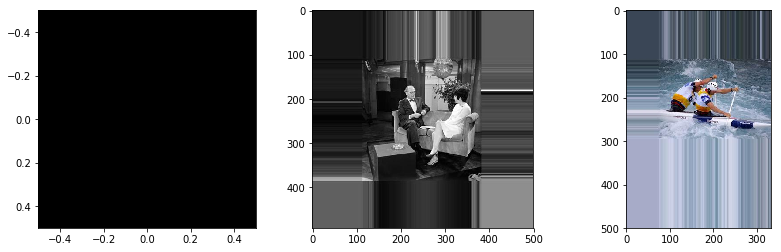

In [9]:
def plot_three(im_list):
    plt.figure(figsize=(14,4))
    for i, array in enumerate(im_list):
        plt.subplot(1, len(im_list), i+1)
        plt.imshow(cv2.cvtColor(array, cv2.COLOR_BGR2RGB))
    plt.show()

# Let's see the images with -inf face_score.
print('face_score of -inf:')
plot_three(im_no_face)

Yup -- none of those have faces. We'll have to remove all of them.

face_score below 0.8:


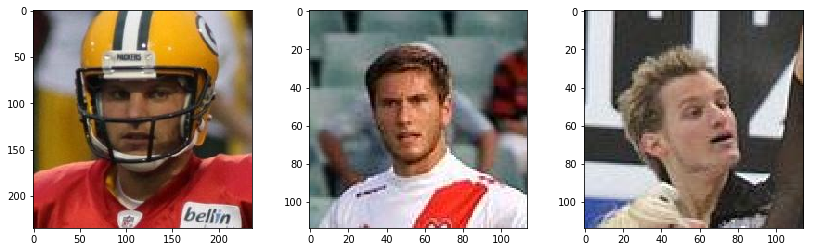

face_score near 1.5:


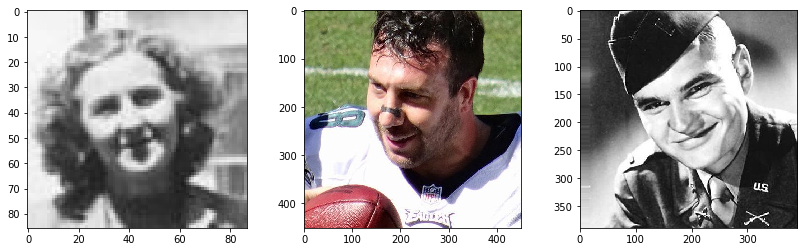

face_score near 3.0:


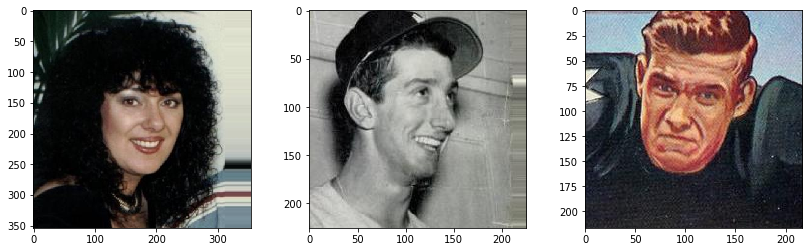

In [10]:
# Now the rest
print('face_score below 0.8:')
plot_three(im_low_face)
print('face_score near 1.5:')
plot_three(im_med_face)
print('face_score near 3.0:')
plot_three(im_high_face)

All those seem fine. We can include all the examples except those with '-inf' face_score.

In [11]:
# Drop elements with negative face_score.
df_face = df_face.drop(df_face[df_face.face_score<0].index).reset_index(drop=True)
print(df_face.shape)

(40216, 9)


Well, we've had to eliminate a third of our dataset, but those images were not going to help with our model. Since we're curious about age, let's take a look at its distribution.

In [12]:
df_face.age.describe()

count    40216.000000
mean        37.603690
std         19.651236
min        -40.000000
25%         25.000000
50%         32.000000
75%         48.000000
max       1995.000000
Name: age, dtype: float64

Oops -- we've got some bad values in here. Anything below 5 or above 100 is probably a mistake... There are only 61 of them, so let's just remove them.

In [13]:
# Drop age outliers.
print('Age outliers:', len(df_face[(df_face.age < 5) | (df_face.age > 100)]))
df_face = df_face.drop(df_face[(df_face.age < 5) | (df_face.age > 100)].index).reset_index(drop=True)
print('New shape:', df_face.shape)

Age outliers: 61
New shape: (40155, 9)


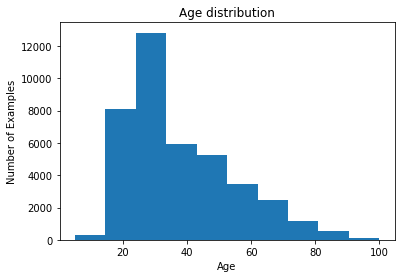

In [14]:
plt.hist(df_face.age)
plt.xlabel('Age')
plt.ylabel('Number of Examples')
plt.title('Age distribution')
plt.show()

This looks completely reasonable. People must love being photographed in their 30's! 

## Image Preprocessing

For our model, we'll have to resize all our images and put them into an array. We should have gotten rid of all the bad images by using the face_score, but let's see if there are any tiny images we might need to worry about. It would be nice to process with as large a standard image size as possible, without having to upsize too many images. Doing so may have adverse effects on our CNN.

I hesitate to load all the images in just to get their sizes, but it actually goes pretty quickly, and it will be valuable to have the original dimensions stored in the dataframe. Let's visualize the dimension distribution of our images.

In [15]:
# Create our new features
df_face['x_dim'] = 0
df_face['y_dim'] = 0

# Iterate over the rows to grab the image size.
for index, row in df_face.iterrows():
    image = cv2.imread(df_face.loc[index, 'file_path'])
    df_face.loc[index, 'x_dim'] = image.shape[0]
    df_face.loc[index, 'y_dim'] = image.shape[1]

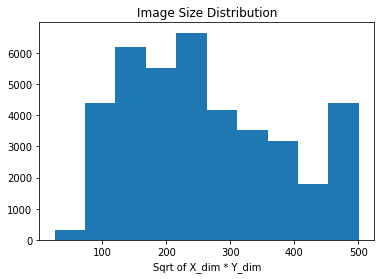

In [16]:
plt.hist(np.sqrt(np.multiply(df_face.x_dim, df_face.y_dim)))
plt.xlabel('Sqrt of X_dim * Y_dim')
plt.title('Image Size Distribution')
plt.show()

In [17]:
print('Number of small images:', df_face[(df_face.x_dim < 90) | (df_face.y_dim < 90)].shape[0])

Number of small images: 1218


We have a lot of images right around 150-250 by 150-250 pixels. We want to avoid upsizing too many of our images, but we also want to keep as high resolution as possible (even though that will increase processing time). Only about 3% of our remaining images are below 90x90 pixels, so I'm going to go ahead and drop those images and rescale everything else to 150x150 pixels. This is a judgment call, but it seems like a good balance based on the data we're dealing with.

In [18]:
# Drop small images.
df_face = df_face.drop(df_face[(df_face.x_dim < 90) | (df_face.y_dim < 90)].index).reset_index(drop=True)
print('New shape:', df_face.shape)

New shape: (38937, 11)


Great! We're ready to go and make our array of image data.

In [19]:
# Create our file array, load the images and resize them with cv2.

file_array = []
for file in df_face.file_path:
    file_array.append(cv2.resize(cv2.imread(file), (150,150)))
file_array = np.asarray(file_array)

print('Final shape:', file_array.shape)

Final shape: (38937, 150, 150, 3)


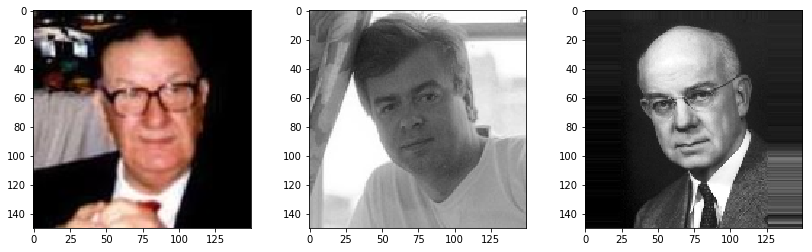

Ages: 80 37 63


In [20]:
# Let's make sure it worked.
im_check = [file_array[100], file_array[1000], file_array[10000]]
plot_three(im_check)
print('Ages:', df_face.age[100], df_face.age[1000], df_face.age[10000])

Great! I wonder if our poor resolution photos will do significantly worse...

## Splitting the Data

Let's get our X and Y arrays all ready to go. We'll split our data into training, validation, and test sets. We won't touch the test set until everything is tuned up and finalized. At this point I would like to normalize the data, however, dividing by 255 with convert int to float and eats up the memory on my machine. I'll see if I can do it later on in batches instead.

In [21]:
from sklearn.model_selection import train_test_split

In [23]:
# Split the data to get the test set, then split it again to get the val set.
# Let's also split the dataframe indices in case we want to refer back to it later.

X, X_test, Y, Y_test, ind, ind_test = train_test_split(file_array/255, np.array(df_face.age), np.array(df_face.index), test_size=0.15, random_state=50)
X_train, X_val, Y_train, Y_val, ind_train, ind_val = train_test_split(X, Y, ind, test_size=0.1, random_state=50)
print('Training sizes:', X_train.shape, Y_train.shape)
print('Validation sizes:', X_val.shape, Y_val.shape)
print('Testing sizes:', X_test.shape, Y_test.shape)

Training sizes: (29786, 150, 150, 3) (29786,)
Validation sizes: (3310, 150, 150, 3) (3310,)
Testing sizes: (5841, 150, 150, 3) (5841,)


# Modeling

## A Quick Model

Let's make a quick neural net just to get us started.

In [24]:
import tensorflow as tf

# Import some basic layers.
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.optimizers import RMSprop

# Import the backend.
from keras import backend as K

Using TensorFlow backend.


In [25]:
# Grab a sample to make sure things are running properly.
X_sample = X_train[:200]
Y_sample = Y_train[:200]

In [26]:
quick_model = Sequential()

quick_model.add(Flatten(input_shape=X_train[0].shape))
quick_model.add(Dense(128, activation='relu'))
quick_model.add(Dropout(.1))
quick_model.add(Dense(1, activation='relu'))

quick_model.summary()

quick_model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['mse'])

quick_model.fit(X_sample, Y_sample,
                batch_size=16,
                epochs=3,
                verbose=1,
                validation_data=(X_sample, Y_sample))

score = quick_model.evaluate(X_sample, Y_sample, verbose=0)
print('Sample Loss:', score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8640128   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 8,640,257
Trainable params: 8,640,257
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 200 samples
Epoch 1/3
200/200 [==============================] - 1s - loss: 1980.9822 - mean_squared_error: 1980.9822 - val_loss: 1724.6500 - val_mean_squared_error: 1724.6500
Epoch 2/3
200/200 [==============================] - 0

Alright! We've got everything queued up. Now we can start to process a large amount of data, preferably on a machine better than my laptop.

## Dense Neural Network

Before we try out a CNN for this dataset, let's see if we can do anything with a standard densely connected NN.

In [29]:
dense_model = Sequential()

dense_model.add(Flatten(input_shape=X_train[0].shape))
dense_model.add(Dense(256, activation='relu'))
dense_model.add(Dropout(.1))
dense_model.add(Dense(128, activation='relu'))
dense_model.add(Dropout(.1))
dense_model.add(Dense(128, activation='relu'))
dense_model.add(Dropout(.1))
dense_model.add(Dense(1, activation='relu'))

dense_model.summary()

dense_model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['mse'])

dense_model.fit(X_train, Y_train,
                batch_size=128,
                epochs=20,
                verbose=1,
                validation_data=(X_val, Y_val))

score = dense_model.evaluate(X_val, Y_val, verbose=0)
print('Sample Loss:', score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               17280256  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

In [30]:
print(dense_model.predict(X_val[:10]), Y_val[:10])

[[ 32.21445465]
 [ 30.97547913]
 [ 32.5095253 ]
 [ 27.85793304]
 [ 42.69763184]
 [ 35.14009857]
 [ 38.38154984]
 [ 21.69588852]
 [ 34.10822296]
 [ 19.75678253]] [35 37 20 43 21 35 24 29 54 29]


In [32]:
cnn_model = Sequential()

# First convolutional layer, note the specification of shape

cnn_model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(150, 150, 3)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='linear'))

cnn_model.summary()

cnn_model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])

cnn_model.fit(X_train, Y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_val, Y_val))
score = cnn_model.evaluate(X_val, Y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 146, 146, 32)      2432      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 144, 144, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 72, 72, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 72, 72, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 331776)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               42467456  
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
__________

In [33]:
cnn_model.fit(X_train, Y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(X_val, Y_val))
score = cnn_model.evaluate(X_val, Y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 29786 samples, validate on 3310 samples
Epoch 1/5
29786/29786 [==============================] - 155s - loss: 202.8876 - mean_squared_error: 202.8876 - val_loss: 169.7855 - val_mean_squared_error: 169.7855
Epoch 2/5
29786/29786 [==============================] - 155s - loss: 185.8510 - mean_squared_error: 185.8510 - val_loss: 173.0101 - val_mean_squared_error: 173.0101
Epoch 3/5
29786/29786 [==============================] - 154s - loss: 167.4306 - mean_squared_error: 167.4306 - val_loss: 171.1377 - val_mean_squared_error: 171.1377
Epoch 4/5
29786/29786 [==============================] - 154s - loss: 149.3249 - mean_squared_error: 149.3249 - val_loss: 155.7894 - val_mean_squared_error: 155.7894
Epoch 5/5
29786/29786 [==============================] - 154s - loss: 138.4318 - mean_squared_error: 138.4318 - val_loss: 157.1738 - val_mean_squared_error: 157.1738
Test loss: 157.173772755
Test accuracy: 157.173772755


In [34]:
print([int(x) for x in cnn_model.predict(X_val[:10])], Y_val[:10])

[43, 36, 27, 29, 34, 29, 29, 24, 41, 32] [35 37 20 43 21 35 24 29 54 29]
